In [4]:
!pip install emd

In [51]:
import matplotlib.pyplot as plt
import emd
#import mne
from scipy.io import loadmat
import numpy as np
from scipy import ndimage

path = r"C:\Users\Camila\OneDrive - Universidade Federal do Pará - UFPA\Documentos\LABNEP\EEG TESTE\DATASET\cleaned0_50Hz"
file = r"0000101_50hz.set"

matdat1 = loadmat(f'{path}\{file}')
matdat = matdat1['data'].flatten()

time = matdat1['times'].flatten()
sample_rate = 200


In [17]:
config = emd.sift.get_config('mask_sift')
config['max_imfs'] = 7
config['mask_freqs'] = 50/sample_rate
config['mask_amp_mode'] = 'ratio_sig'
config['imf_opts/sd_thresh'] = 0.05

###1. extraindo IMFs
from functools import partial
my_mask_sift = partial(emd.sift.mask_sift, **config)
imf = my_mask_sift(matdat)

###2. calculando o conteudo das imfs (fase, freq e amplitude instantaneas)
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')

In [18]:
###1.1 second level sift: extraindo mais imfs de cada imf
#decompoe a amplitude instantanea de cada IMF1
def mask_sift_second_layer(IA, masks, config={}):
    imf2 = np.zeros((IA.shape[0], IA.shape[1], config['max_imfs']))
    for ii in range(IA.shape[1]):
        config['mask_freqs'] = masks[ii:]
        tmp = emd.sift.mask_sift(IA[:, ii], **config)
        imf2[:, ii, :tmp.shape[1]] = tmp
    return imf2


# Define sift parameters for the second level
masks = np.array([25/2**ii for ii in range(12)])/sample_rate
config = emd.sift.get_config('mask_sift')
config['mask_amp_mode'] = 'ratio_sig'
config['mask_amp'] = 2
config['max_imfs'] = 5
config['imf_opts/sd_thresh'] = 0.05
config['envelope_opts/interp_method'] = 'mono_pchip'

# Sift the first 5 first level IMFs
imf2 = emd.sift.mask_sift_second_layer(IA, masks, sift_args=config)

##2.2. calculando o conteudo da imf2
IP2, IF2, IA2 = emd.spectra.frequency_transform(imf2, sample_rate, 'nht')

In [21]:
###3. definindo os bins de frequencia que serão usados no histograma
carrier_hist = (1, 100, 128, 'log') # Carrier frequency histogram 
am_hist = (1e-2, 32, 64, 'log') # AM frequency histogram

###4. 1d, 2d e 3d hilbert huang transform
#(power over carrier frequency)
fcarrier, spec = emd.spectra.hilberthuang(IF, IA, carrier_hist, sum_imfs=False)

#power over time x carrier frequency)
fcarrier, hht = emd.spectra.hilberthuang(IF, IA, carrier_hist, sum_time=False)
shht = ndimage.gaussian_filter(hht, 2)

#time averaged Holospectrum (power over carrier frequency x AM frequency)
fcarrier, fam, holo = emd.spectra.holospectrum(IF, IF2, IA2, carrier_hist, am_hist)
sholo = ndimage.gaussian_filter(holo, 1)
#multidimensional Gaussian filter 
#(input array, sigma = standard deviation for Gaussian kernel)

([<matplotlib.axis.YTick at 0x2b188cab940>,
 [Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 4, '4'),
  Text(0, 8, '8'),
  Text(0, 16, '16'),
  Text(0, 32, '32'),
  Text(0, 64, '64')])

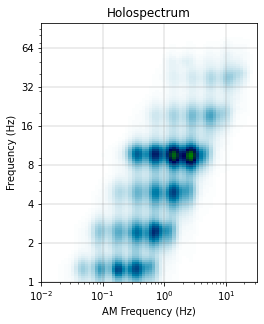

In [36]:
# Plot a the Holospectrum
plt.axes([.75, .1, .500, .9])
plt.pcolormesh(fam, fcarrier, sholo, cmap='ocean_r', shading='nearest')
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.yscale('log')
plt.xscale('log')
plt.title('Holospectrum')
plt.xlabel('AM Frequency (Hz)')
plt.ylabel('Frequency (Hz)')
plt.yticks(2**np.arange(7), 2**np.arange(7))


In [38]:
loadmat(f'{path}\{file}')

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Dec  5 16:22:48 2022',
 '__version__': '1.0',
 '__globals__': [],
 'setname': array(['0000101 pruned with ICA'], dtype='<U23'),
 'filename': array(['0000101_50hz.set'], dtype='<U16'),
 'filepath': array(['C:\\Users\\Camila\\OneDrive - Universidade Federal do Par� - UFPA\\Documentos\\LABNEP\\DATASET\\cleaned0_50Hz'],
       dtype='<U102'),
 'subject': array([], dtype='<U1'),
 'group': array([], dtype='<U1'),
 'condition': array([], dtype='<U1'),
 'session': array([], shape=(0, 0), dtype=uint8),
 'comments': array([], dtype='<U1'),
 'nbchan': array([[16]], dtype=uint8),
 'trials': array([[1]], dtype=uint8),
 'pnts': array([[76211]]),
 'srate': array([[200]], dtype=uint8),
 'xmin': array([[0]], dtype=uint8),
 'xmax': array([[381.05224484]]),
 'times': array([[0.00000000e+00, 5.00002946e+00, 1.00000589e+01, ...,
         3.81042245e+05, 3.81047245e+05, 3.81052245e+05]]),
 'data': array([[  34.428917 ,   -1.1415622,   

([<matplotlib.axis.YTick at 0x2b18ab3f6a0>,
 [Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 4, '4'),
  Text(0, 8, '8'),
  Text(0, 16, '16'),
  Text(0, 32, '32'),
  Text(0, 64, '64')])

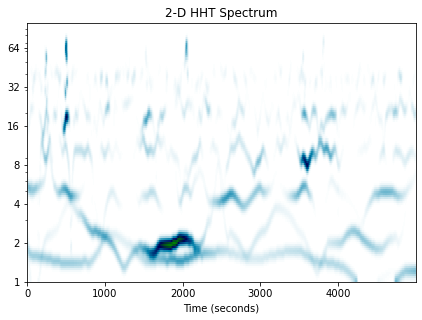

In [53]:
# Plot a section of the Hilbert-Huang transform
plt.axes([.325, .1, .9, .9])
plt.pcolormesh(time[:sample_rate*5], fcarrier, shht[:, :sample_rate*5], cmap='ocean_r', shading='nearest')
plt.yscale('log')
plt.title('2-D HHT Spectrum')
plt.xlabel('Time (seconds)')
plt.yticks(2**np.arange(7), 2**np.arange(7))